In [13]:
import numpy as np, prjlib, plottools as pl, tools_y, tools_qrec, pickle, binning as bn, analysis as ana
from scipy.signal import savgol_filter
from matplotlib.pyplot import *

In [10]:
def plot_cov(cov,bins=None,xlab='L1',ylab='L2',zmin=-1,zmax=1,clab='cov'):
    #cor = np.corrcoef(dat,rowvar=0)
    # normalized by the diagonals
    dcov = np.diag(1./np.sqrt(np.diag(cov)))
    ncov = np.matmul(np.matmul(dcov,cov),dcov)
    if bins is None:
        bn = len(cov[0])
        x = np.linspace(1,bn,bn)
    else:
        x = bins
    xlabel(xlab)
    ylabel(ylab)
    pcolor(x,x,ncov,vmin=zmin,vmax=zmax)
    cb = colorbar()
    cb.set_label(clab,labelpad=20,rotation=270)
    axhline(10)
    axvline(10)
    show()

In [14]:
def prep_cov(mb,snmax=100,dtype='dr2_smica',mtype=0,cmask='Lmask',ytype='nilc',est='bh-lens-src',fltr='cinv'):
    p = prjlib.init_analysis(snmax=snmax,dtype=dtype,fltr=fltr,wtype=cmask)
    qtau, __, __, qtbh, qtBH = tools_qrec.init_quad(p.ids,p.stag,rlmin=100,rlmax=2048)
    cy = tools_y.init_compy(p.ids,masktype=mtype,ytype=ytype,ascale=1.)

    if est=='bh-lens-src':
        qobj = qtBH
        bh = est
        fx = tools_y.init_cross(qtBH,cy,p.ids,p.stag)
    if est=='bh-lens':
        qobj = qtbh
        fx = tools_y.init_cross(qtbh,cy,p.ids,p.stag)
        bh = est
    if est=='':
        fx = tools_y.init_cross(qtau,cy,p.ids,p.stag)
        bh = 'bh-none'

    # tau x tau
    al = (np.loadtxt(qobj.f['TT'].al)).T[1]
    vl = al/np.sqrt(qobj.l+1e-30)
    mtt, __, stt, ott = bn.binned_spec(mb,qobj.f['TT'].cl[:snmax+1],cn=1,doreal=True,opt=True,vl=vl)
    n0 = (np.loadtxt(qobj.f['TT'].n0bs)).T[1]
    nb = bn.binning(n0,mb,vl=vl)
    rd = np.array( [ (np.loadtxt(qobj.f['TT'].rdn0[i])).T[1] for i in p.rlz ] )
    rb = bn.binning(rd,mb,vl=vl)

    # debias
    ott = ott - rb[0] - nb/(qobj.mfsim)
    mtt = mtt - np.mean(rb[1:,:],axis=0) - nb/(qobj.mfsim-1)
    ott = ott - mtt # subtract average of sim
    stt = stt - rb[1:,:] - nb/(qobj.mfsim-1)
    vtt = np.std(stt,axis=0)
    #stt = stt - nb - nb/(qobj.mfsim-1)

    # PTE for tauxtau
    st = ana.PTEs(ott,stt-mtt,x1pte=True)

    # tau x y
    yy = (np.loadtxt(cy.fclyy)).T[1]
    yy = savgol_filter(yy, 51, 3)
    vl = np.sqrt(al*yy)/np.sqrt(qobj.l+1e-30)
    __, vty, sty, oty = bn.binned_spec(mb,fx.xl[:snmax+1],cn=1,opt=True,vl=vl)
    if mtype==0: ymask = 'G60'
    if mtype==1: ymask = 'G50'
    tag = dtype+'_'+cmask+'_'+ytype+'_'+ymask+'_'+bh
    
    # PTE for tauxy
    st = ana.PTEs(oty,sty,x1pte=True)

    # output spec
    ocb = np.concatenate((ott,oty))
    vcb = np.concatenate((vtt,vty))
    bc2 = np.concatenate((mb.bc,mb.bc))
    np.savetxt('../v2.2/cl_'+tag+'.dat',np.array((bc2,ocb,vcb)).T)
    
    # calc cov
    scb = np.concatenate((stt,sty),axis=1)
    cov = np.cov(scb,rowvar=0)
    np.savetxt('../v2.2/covariance_'+tag+'.dat',cov)

    # plot tau x tau
    pl.plot_1dstyle(fsize=[10,4],ylab=r'$10^5 LC_L^{\tau\tau}$',ymin=-1.5,ymax=1.5,xmin=1,xmax=2048)
    s = mb.bc * 1e5
    bns = len(mb.bc)
    errorbar(mb.bc,s*ocb[:bns],yerr=s*vcb[:bns],fmt='o')
    axhline(0,color='k',ls='--')
    savefig('../v2.2/fig_tauxtau_'+tag+'.png')
    show()

    # plot tau x y
    pl.plot_1dstyle(fsize=[10,4],ylab=r'$10^8 L^2C_L^{\tau y}/2\pi$',ymin=-1,ymax=1,xmin=1,xmax=2048)
    s = mb.bc**2/(2*np.pi)*1e8
    errorbar(mb.bc,s*ocb[bns:],yerr=s*vcb[bns:],fmt='o')
    axhline(0,color='k',ls='--')
    savefig('../v2.2/fig_tauxy_'+tag+'.png')
    show()
    
    # plot covariance
    plot_cov(cov)

    return bc2, ocb, vcb, cov

chi: -4.9 , chi (sim): 0.0 , PTE: 0.20 
chi^2: 17.7 , chi^2 (sim): 11.2 , PTE: 0.14 
chi: -2.5 , chi (sim): -0.0 , PTE: 0.44 
chi^2: 16.0 , chi^2 (sim): 11.1 , PTE: 0.18 


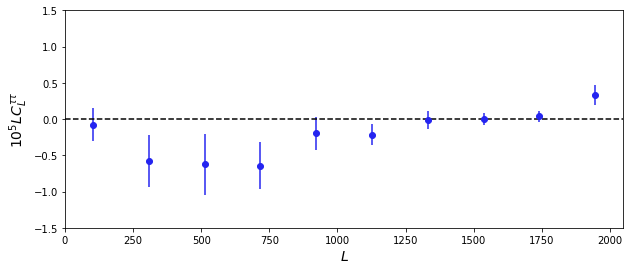

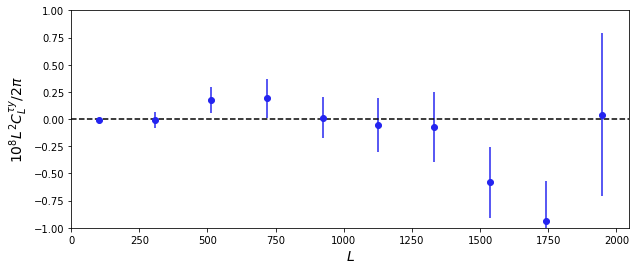

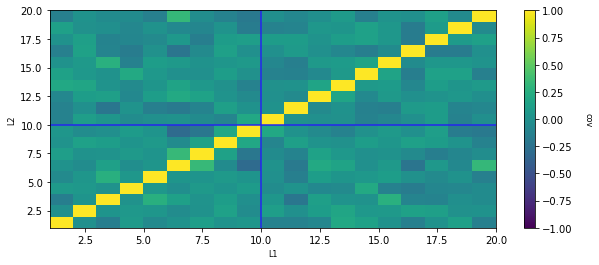

In [15]:
mb = bn.multipole_binning(10,lmin=1,lmax=2048)
bc2, ocb, vcb, cov = prep_cov(mb)

In [ ]:
mb = bn.multipole_binning(10,lmin=1,lmax=2048)
__, ocb, vcb0, cov0 = prep_cov(mb,dtype='dr2_nilc')

In [ ]:
mb = bn.multipole_binning(10,lmin=1,lmax=2048)
__, ocb2, vcb2, cov2 = prep_cov(mb,snmax=100,cmask='G60Lmask')

In [ ]:
mb = bn.multipole_binning(10,lmin=20,lmax=2048)
__, ocb0, vcb0, cov0 = prep_cov(mb,dtype='dr3_nosz',cmask='LmaskDR3')

Plot Correlation Coefficients

Other cases

In [ ]:
mb = bn.multipole_binning(10,lmin=1,lmax=2048)
__, ocb1, vcb1, cov1 = prep_cov(mb,ytype='milca')
__, ocb3, vcb3, cov3 = prep_cov(mb,mtype=1)
#__, ocb4, vcb4, cov4 = prep_cov(mb,est='bh-lens')
#__, ocb5, vcb5, cov5 = prep_cov(mb,est='')